In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau

In [3]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x, weights = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout, 
                                           attention_axes=(2)
                                          )(x, x, return_attention_scores=True)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [4]:
def build_model(input_shape,head_size, num_heads,ff_dim,num_transformer_blocks,mlp_units,dropout=0, mlp_dropout=0):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

In [5]:
####
import tensorflow.keras.backend as K
def clear_sess():
  try:
    del model 
    del history 
  except:
    pass
  from tensorflow.keras import backend as K
  K.clear_session()
  import gc
  gc.collect()



  return None
clear_sess()

In [6]:
model = build_model((48, 26),head_size=32,num_heads=26,ff_dim=4,num_transformer_blocks=1,mlp_units=[128],mlp_dropout=0.4,dropout=0.25)

2023-03-07 20:54:42.923693: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-07 20:54:43.161773: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-07 20:54:43.161953: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-07 20:54:43.162366: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 26)]     0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 48, 26)      52          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  ((None, 48, 26),    89050       ['layer_normalization[0][0]',    
 dAttention)                     (None, 48, 26, 26)               'layer_normalization[0][0]']    
                                )                                                             

In [ ]:
import numpy as np

In [19]:
data = np.load('train_test_x_y_01.npz')
train_x, test_x, train_y, test_y  = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3'] 

In [10]:
train_y = train_y.reshape(-1,1)
test_y  = test_y.reshape(-1,1)

In [11]:
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((18390, 43, 21), (4598, 43, 21), (18390, 1), (4598, 1))

In [12]:
def keras_mcc(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))

    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    return num / K.sqrt(den + K.epsilon())

In [13]:
metrics_c = [keras.metrics.AUC(name="auc_roc",curve="ROC"),keras.metrics.AUC(name="auc_pr",curve="PR"),keras_mcc]

In [15]:
from datetime import datetime

now = datetime.now() 

In [16]:
# callbacks = [keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True),]
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.99,patience=50, min_lr=0.001, verbose=1)

checkpoint_filepath_4 = f'weights-improvement-val-keras-mcc-{now}.hdf5'
model_checkpoint_callback_4 = ModelCheckpoint(filepath=checkpoint_filepath_4,save_weights_only=False,monitor='val_keras_mcc',mode='max',save_best_only=True)

In [17]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.1), loss='binary_crossentropy', metrics=metrics_c, weighted_metrics=[])

In [18]:
train_history=model.fit(train_x,train_y,validation_split=0.2, epochs=300,
                        verbose=1,
                        batch_size=128,callbacks=[reduce_lr, model_checkpoint_callback_4])


Epoch 1/300


ValueError: in user code:

    File "/home/shashank/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/home/shashank/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/shashank/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "/home/shashank/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "/home/shashank/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/shashank/anaconda3/lib/python3.9/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 48, 26), found shape=(None, 43, 21)


In [125]:
model.save('mimic3_ts_transformer_4march_wattscores_48x26x26.h5')

In [29]:
##### model load
### load keras model
from tensorflow import keras

model = keras.models.load_model('weights-improvement-val-keras-mcc-2023-03-07 19:39:49.664918.hdf5', compile=False)

In [30]:
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, average_precision_score, matthews_corrcoef

In [32]:
print(roc_auc_score(train_y, model.predict(train_x, verbose=0)))
print(average_precision_score(train_y, model.predict(train_x, verbose=0)))
print(f1_score(train_y, np.round(model.predict(train_x, verbose=0))))
print(recall_score(train_y, np.round(model.predict(train_x, verbose=0))))
print(precision_score(train_y, np.round(model.predict(train_x, verbose=0))))
print(matthews_corrcoef(train_y, np.round(model.predict(train_x, verbose=0))))

0.8986881695730397
0.6079587868103491
0.5089883679943603
0.3941048034934498
0.718407960199005
0.4967673500389786


In [33]:
print(roc_auc_score(test_y, model.predict(test_x, verbose=0)))
print(average_precision_score(test_y, model.predict(test_x, verbose=0)))
print(f1_score(test_y, np.round(model.predict(test_x, verbose=0))))
print(recall_score(test_y, np.round(model.predict(test_x, verbose=0))))
print(precision_score(test_y, np.round(model.predict(test_x, verbose=0))))
print(matthews_corrcoef(test_y, np.round(model.predict(test_x, verbose=0))))

0.7103954391072295
0.26748500622646976
0.2347560975609756
0.16812227074235808
0.3888888888888889
0.2049091107900389


In [132]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 26)]     0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 48, 26)      52          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  ((None, 48, 26),    89050       ['layer_normalization[0][0]',    
 dAttention)                     (None, 48, 26, 26)               'layer_normalization[0][0]']    
                                )                                                             

In [133]:
import matplotlib.pyplot as plt
import timeit

In [134]:
#### for multi_head_attention 
att_layerout_MHA0= keras.Model(inputs=model.input, outputs=model.get_layer('multi_head_attention').output)

In [135]:
att_output_MHA0 = att_layerout_MHA0.predict(test_x)

144/144 [==============================] - 0s 2ms/step


2023-03-04 02:01:48.052524: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 596783616 exceeds 10% of free system memory.


In [136]:
att_outvals_MHA0, att_scores_MHA0 = att_output_MHA0

In [137]:
att_scores_MHA0 = att_scores_MHA0.squeeze()

In [138]:
att_outvals_MHA0.shape, att_scores_MHA0.shape

((4598, 48, 26), (4598, 48, 26, 26))

In [211]:
temp_att_scores_dim2 = np.mean(att_scores_MHA0,axis=2) ###the right way
# temp_att_scores_dim3 = np.mean(att_scores_MHA0,axis=3)

In [212]:
temp_att_scores_dim2.shape, temp_att_scores_dim3.shape, 

((4598, 48, 26), (4598, 48, 26))

In [213]:
import seaborn as sns
import matplotlib.pyplot as plt

In [214]:
# sns.set(rc={'figure.figsize':(11.7,8.27)})
# ax = sns.heatmap(att_scores_MHA0[0,0, :,:], cmap='BuPu')
# ax.xaxis.tick_top()
# plt.show()

In [215]:
from util import heat_map

In [269]:
num_background = 15
num_test = index = 0

var = 18
phi_index = 0

In [270]:
test_x[num_test + phi_index, :, var].shape, temp_att_scores[phi_index, :, var].shape

((48,), (48,))

[0.         0.00281586 0.00781586 0.01281586 0.01781586 0.02281586
 0.02781586 0.03281586 0.03781586 0.04281586 0.04781586 0.05281586
 0.05781586 0.06281586 0.06781586 0.07281586 0.07781586 0.08281586
 0.08781586 0.09281586 0.09781586 0.10281586 0.10781586 0.11281586
 0.11781586 0.12281586 0.12781586 0.13281586 0.13781586 0.14281586
 0.14781586 0.15281586 0.15781586 0.16281586 0.16781586 0.17281586
 0.17781586 0.18281586 0.18781586 0.19281586 0.19781586 0.20281586
 0.20781586 0.21281586 0.21781586]


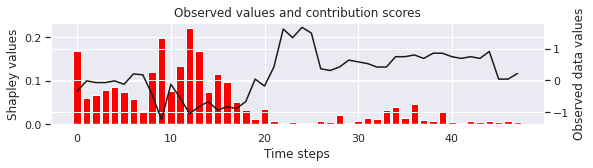

In [271]:
heat_map(start=0, stop=48, x=test_x[num_test + phi_index, :, var], shap_values=temp_att_scores_dim2[phi_index, :, var], var_name='Observed', plot_type='bar')

In [220]:
# heat_map(start=0, stop=48, x=test_x[num_test + phi_index, :, var], shap_values=temp_att_scores_dim3[phi_index, :, var], var_name='Observed', plot_type='bar')

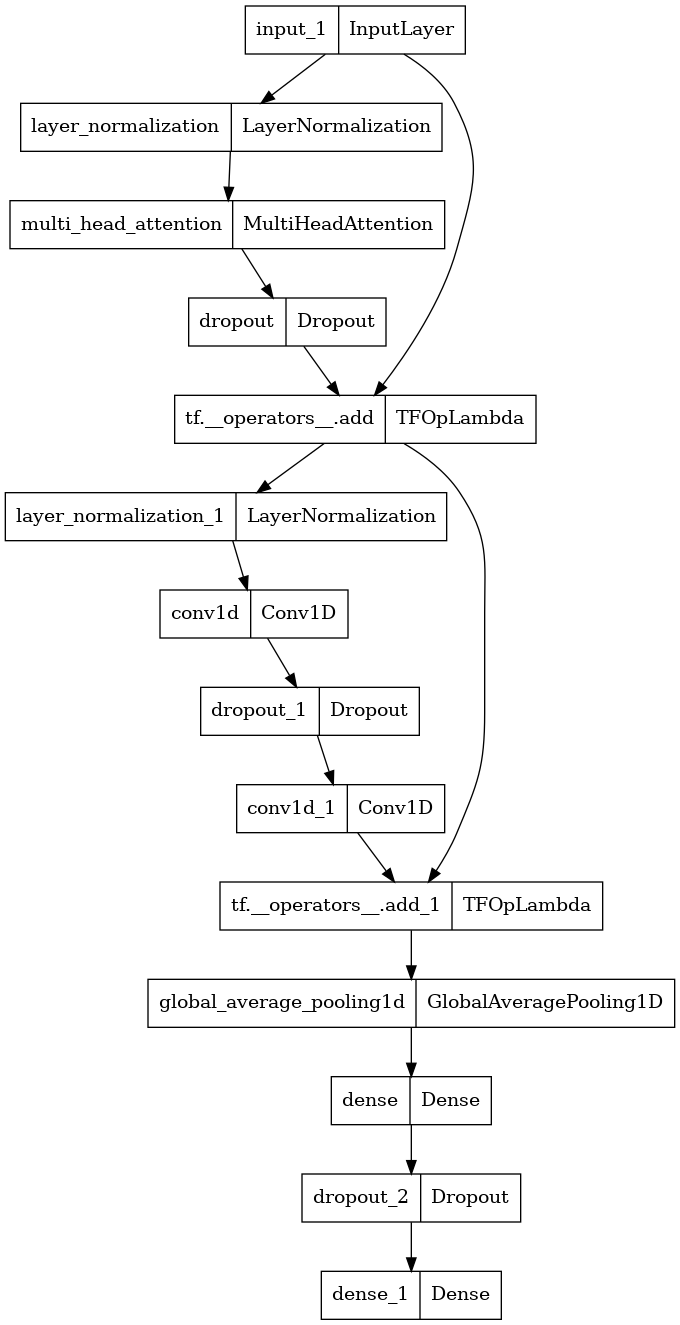

In [272]:
keras.utils.plot_model(model)